# Predicting median house value using PySpark and MLlib

**The first objective** is to train Linear Regression model on California 1990 housing data using PySpark and MLlib. Predictions are made on test data. Model's quality is estimated using RMSE, MAE and R2.

**The second objective** is to compare two models trained on different feature sets:
* a model trained using all features
* a model trained usig only numerical features

**NOTE:**

For this project a modified dataset was used, based on this data: https://www.kaggle.com/datasets/camnugent/california-housing-prices. The main purpose of this project is to get expierenced with distributed file system and evaluating technologies so score values and models used are not important here. Actual dataset is not available for sharing.

Target feature is `median_house_proximity`

In [1]:
# imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml import Pipeline

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
    
# random state
RND = 1337

In [2]:
# checking pyspark version
pyspark.__version__

'3.0.2'

In [3]:
# initialising local pyspark session
spark = SparkSession.builder \
                    .master("local") \
                    .appName("ML California Housing") \
                    .getOrCreate()

## Data preparation

### Open the dataset

In [4]:
# open the dataset
df_housing = spark.read.csv('./datasets/housing.csv', header=True, inferSchema=True)

In [5]:
# dataset scheme
df_housing.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



All columns' types are numeric except for `ocean_proximity` which is a string type. Columns `longitude` and `latitude` mean coordinates; theese features are individual and don't affect target directly, so we will remove them from processing.

In [6]:
# removing longitude and latitude columns
df_housing = df_housing.select([col for col in df_housing.columns if col not in ['longitude', 'latitude']])
df_housing.show(3)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
only showing top 3 rows



Check statistics and missing values using `describe()` method

In [7]:
df_describe = df_housing.describe().toPandas()
df_describe

,summary,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


### Fill missing values

Let's count all the objects in the dataset and compare this data to the row `count` of the table above. Thus we will know how much missing values are there. Due to `summary` column being object type the Series object is not numeric so we fix that too

In [8]:
total_count = df_housing.count()
print(f'Всего строк в датафрейме: {total_count}')
pd.to_numeric(df_describe.loc[0, 'housing_median_age':]) - total_count

Всего строк в датафрейме: 20640


housing_median_age      0
total_rooms             0
total_bedrooms       -207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
Name: 0, dtype: int64

Column `total_bedrooms` has less values than there are objacts in the dataset, so that means there are missing values

We will check data distribution for this column in order to understand how to deal with the missing values

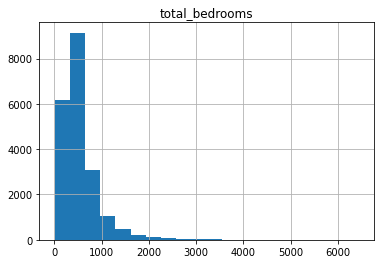

,total_bedrooms
mean,537.870553
median,435.000000


In [9]:
df_total_bedrooms = df_housing.select('total_bedrooms').toPandas()
df_total_bedrooms.hist(bins=20)
plt.show()
df_total_bedrooms.agg(['mean', 'median'])

Distribution is shifted to the left so we will use median values to fill in missing data

In [10]:
# saving median value to the variable
total_bedrooms_median = df_total_bedrooms.median()[0]
total_bedrooms_median

435.0

Filling missing values in `total_bedrooms` using median value

In [11]:
# only one column
df_housing = df_housing.na.fill({'total_bedrooms': total_bedrooms_median})

In [12]:
df_housing.describe().toPandas()

,summary,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20640,20640,20640,20640
1,mean,28.639486434108527,2635.7630813953488,536.8388565891473,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,12.58555761211163,2181.6152515827944,419.39187792168866,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


### Split the data

In [13]:
# split data on train and test samples
df_train, df_test = df_housing.randomSplit([0.8, 0.2], seed=RND)
print(df_train.count(), df_test.count())

16565 4075


## Build a pipeline

### OHE and standartisation

In [14]:
# list to append stages
stages = []
# numeric columns
num_cols = [col for col in df_housing.columns if col not in ['median_house_value', 'ocean_proximity']]
# categorical columns (only one)
cat_cols = ['ocean_proximity']
# target
target = 'median_house_value'

display(num_cols, cat_cols, target)

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

['ocean_proximity']

'median_house_value'

There is only one categorical feature - ocean proximity. We will process it using OHE and add to the pipepline stages

In [15]:
# string values to numeric
encoder_idx = StringIndexer(inputCols=cat_cols, outputCols=[col + '_idx' for col in cat_cols])
stages += [encoder_idx]

# OHE
encoder_ohe = OneHotEncoder(inputCols=[col + '_idx' for col in cat_cols], outputCols=[col + '_ohe' for col in cat_cols])
stages += [encoder_ohe]

We will add pipeline stages that assemble numeric features to a vector and standartise them then

In [16]:
# assembling a vector
num_assembler = VectorAssembler(inputCols=num_cols, outputCol='num_features')
stages += [num_assembler]

# scaling features
scaler_std = StandardScaler(inputCol='num_features', outputCol='num_features_scaled')
stages += [scaler_std]

Add a pipeline stage that assembles a vector of all features

In [17]:
# all features to vector
all_assembler = VectorAssembler(inputCols=['ocean_proximity_ohe', 'num_features_scaled'], outputCol='all_features')
stages += [all_assembler]

In [18]:
# checkin stages
stages

[StringIndexer_a4d438d1deb7,
 OneHotEncoder_5fa8122a4a6c,
 VectorAssembler_594a7cc4d4f7,
 StandardScaler_f145abc32c6d,
 VectorAssembler_67452192c54d]

### Assemble the pipeline

Due to **the second objective** we will assemble **two** pipelines: one for all features training and one for numeric only

In [19]:
# all features trainig
lin_reg_all = LinearRegression(labelCol=target, featuresCol='all_features', regParam=0.01)

# assembling pipeline for all features trainig
pipeline_all = Pipeline(stages=stages+[lin_reg_all])
pipeline_all.getStages()

[StringIndexer_a4d438d1deb7,
 OneHotEncoder_5fa8122a4a6c,
 VectorAssembler_594a7cc4d4f7,
 StandardScaler_f145abc32c6d,
 VectorAssembler_67452192c54d,
 LinearRegression_4658be078f26]

In [20]:
# only numeric features traing
lin_reg_num = LinearRegression(labelCol=target, featuresCol='num_features_scaled', regParam=0.01)

# assenbling pipeline for numeric only trainig
# removing categorical features encoding and vectorising as we don't need those
pipeline_num = Pipeline(stages=stages[2:4]+[lin_reg_num])
pipeline_num.getStages()

[VectorAssembler_594a7cc4d4f7,
 StandardScaler_f145abc32c6d,
 LinearRegression_b3b325905ff7]

## Train models

### Train the models and get predictions

In [21]:
# all features
pred_all = pipeline_all.fit(df_train).transform(df_test)

# numeric features only
pred_num = pipeline_num.fit(df_train).transform(df_test)

print('Обучение на всех признаках')
pred_all.select([target, 'prediction']).show(5)
print('Обучение только на числовых признаках')
pred_num.select([target, 'prediction']).show(5)

23/02/24 20:44:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/24 20:44:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/02/24 20:44:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/24 20:44:51 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Обучение на всех признаках
+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          434700.0|159406.90908675164|
|          237500.0|167878.62979386686|
|          114200.0| 89552.41292299845|
|          298500.0| 312018.2360306425|
|          196700.0|201476.48984807797|
+------------------+------------------+
only showing top 5 rows

Обучение только на числовых признаках
+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          434700.0|111980.78992996781|
|          237500.0|116771.63695244258|
|          114200.0|106869.17784938044|
|          298500.0|285275.20850078337|
|          196700.0|232176.34731505078|
+------------------+------------------+
only showing top 5 rows



### Evaluate scores

In [22]:
# function to evaluate RMSE, MAE and R2
def rmse_mae_r2(data, y_true_col, y_pred_col):
    '''
    Return dictionary with RMSE, MAE and R2 scores
    data - DataFrame object
    y_true_col - column name with true labels (labelCol)
    y_pred_col - column name with predicted labels (predictionCol)
    '''
    return {
        'rmse': RegressionEvaluator(labelCol=y_true_col, predictionCol=y_pred_col, metricName='rmse').evaluate(data),
        'mae': RegressionEvaluator(labelCol=y_true_col, predictionCol=y_pred_col, metricName='mae').evaluate(data),
        'r2': RegressionEvaluator(labelCol=y_true_col, predictionCol=y_pred_col, metricName='r2').evaluate(data)
    }

In [23]:
metrics = pd.DataFrame([rmse_mae_r2(pred_all, target, 'prediction'),
                        rmse_mae_r2(pred_num, target, 'prediction')], index=['all', 'num'])
metrics

,rmse,mae,r2
all,67612.469670,49831.377876,0.649156
num,73593.523899,55163.733340,0.584339


### Stop PySpark session

In [24]:
spark.stop()

# Results

In [25]:
for m in ['rmse', 'mae', 'r2']:
    print(f"Изменение метрики {m}: {((metrics.loc['num', m] - metrics.loc['all', m]) / metrics.loc['all', m]):.3f}")

Изменение метрики rmse: 0.088
Изменение метрики mae: 0.107
Изменение метрики r2: -0.100


* LinReg model trained on all features showed better results on test data than the one trained on only numeric features
* * Scores are *~10%* worse
* Coefficient of determination ($R^2$ score) obtained shows that prediction variance is almost 3 times (**2.849**) lower than variance of target itself